Demonstration and comparison of the studied spectrogram based Vocoder techniques: 

* [Griffin-Lim](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.306.7858&rep=rep1&type=pdf)
* [MelGAN](https://arxiv.org/abs/1910.06711)
* [WaveRNN](https://github.com/fatchord/WaveRNN)

<!-- [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/zakajd/voice-transfer/blob/master/notebooks/Demo.ipynb) -->

In [127]:
import os
import sys
import random 

import torch
import torchaudio
import numpy as np
from IPython import display
import matplotlib.pyplot as plt 

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

sys.path.append("..")
root = ".."

In [128]:
from voice_transfer.audio import melspectrogram2wav
from voice_transfer.modules import Audio2Mel

torch.Size([1, 80, 281])


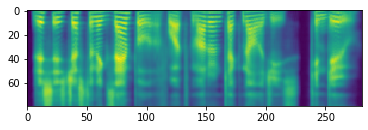

In [129]:
melspectogram = torch.load(os.path.join(root, "results/zakhar_melspectrogram.pt"))
melspectogram = torch.from_numpy(melspectogram)
# There is a big pause in the very end, probably due to some model bug. Manually make it shorter a little bit.
melspectogram = torch.cat((melspectogram[:, :230], melspectogram[:, 290:]), dim=1)
plt.imshow(melspectogram)
# Add batch dimension
melspectogram = melspectogram.unsqueeze(0)
print(melspectogram.shape)

In [130]:
from voice_transfer.melgan import Generator
model = Generator(80, 32, 3)
model.load_state_dict(torch.load(os.path.join(root, "results/melgan_generator.pt"), map_location=device))

<All keys matched successfully>

In [131]:
waveform_melgan = model(melspectogram).squeeze(0)
print(waveform_melgan.shape)
waveform_wavernn, _ = torchaudio.load(os.path.join(root, "results/2_zakhar_generated.wav"))

normed = (melspectogram - melspectogram.min())/ (melspectogram.max() - melspectogram.min())
#Hyperparameters
params = {
    "hop_size" : 256,
    "window_size" : 512,
    "n_fft" : 512,
    "n_mels" : 80,
    "sampling_rate" : 16000,
    "ref_level_db" : 20.,
    "min_level_db" : -80.0, #-80
    "f_min" : 0.0,
    "f_max" : None,
}

waveform_griffinlim = melspectrogram2wav(normed, params)

torch.Size([1, 71936])


In [132]:
print("MelGAN")
display.display(display.Audio(waveform_melgan.detach().numpy(), rate=20000))
print("WaveRNN")
display.display(display.Audio(waveform_wavernn.numpy(), rate=16000))
print("Griffin-Lim")
display.display(display.Audio(waveform_griffinlim.numpy(), rate=18000))

MelGAN


WaveRNN


Griffin-Lim


Let's compare spectrograms of the results we got from those methods

In [138]:
torchaudio.save(os.path.join(root, "results/melgan.wav"), waveform_melgan.detach(), sample_rate=20000)
torchaudio.save(os.path.join(root, "results/wavernn.wav"), waveform_wavernn, sample_rate=16000) 
torchaudio.save(os.path.join(root, "results/griffinlim.wav"), waveform_griffinlim, sample_rate=18000)

In [133]:
print(waveform_griffinlim.shape, waveform_melgan.shape, waveform_wavernn.shape)

torch.Size([1, 71680]) torch.Size([1, 71936]) torch.Size([1, 81400])


In [134]:
audio2mel = Audio2Mel()
_, melspec_griffinlim =  audio2mel(waveform_griffinlim.unsqueeze(0))
_, melspec_wavegan =  audio2mel(waveform_melgan.unsqueeze(0))
_, melspec_wavernn =  audio2mel(waveform_wavernn.unsqueeze(0))


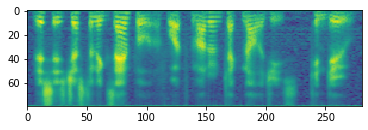

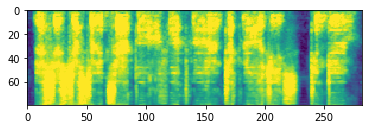

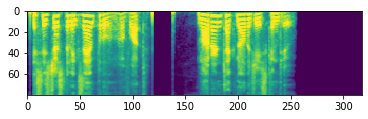

In [135]:
plt.imshow(melspec_griffinlim.squeeze())
plt.show()
plt.imshow(melspec_wavegan.squeeze().detach())
plt.show()
plt.imshow(melspec_wavernn.squeeze())
plt.show()